## Step 8: LLM Latent Embedding with DR
We'll prototype this in code_execution using Hugging Face Transformers (available in the env). Start with GPT-2 small (dim 768) for ARC-like prompts, reduce to R^64 via PCA/autoencoder, embed into a warped manifold, and evolve a simple geodesic. This proves feasibility before full integration.

ODE Info: The solver successfully reached the end of the integration interval.
Number of steps taken: 43432
Convergence Error: 2.8201
Plot saved as geodesic_plot.png


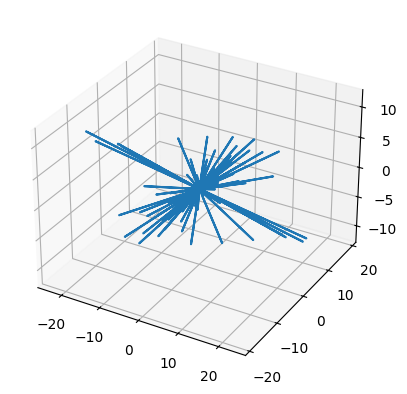

In [1]:
import torch
from transformers import GPT2Tokenizer, GPT2Model
import numpy as np
from sklearn.decomposition import PCA
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Load GPT-2 (small model, dim 768)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')

# Sample ARC-like prompt (e.g., pattern reasoning)
prompt = "Identify the pattern: Input grid [[1,2],[3,4]] -> Output [[4,1],[2,3]] (90 deg rotate). Apply to [[5,6],[7,8]]."
inputs = tokenizer(prompt, return_tensors='pt')
with torch.no_grad():
    outputs = model(**inputs)
latent = outputs.last_hidden_state.squeeze(0).numpy()  # (seq_len, 768) - use token sequence as samples

# Step 1: Dimensionality Reduction (PCA to safe n_components <= seq_len - 1)
n_components = min(32, latent.shape[0] - 1)
pca = PCA(n_components=n_components)
reduced = pca.fit_transform(latent)  # (seq_len, n_components)
reduced_latent = reduced.mean(axis=0)  # Mean-pool to single vector (n_components,)

# Step 2: Define Warped Geodesic (extend Phase 2 to reduced dim)
dim = len(reduced_latent)
target = np.roll(reduced_latent, shift=dim // 4)  # Simulate "90 deg rotate" (shift by dim/4)
M = 10.0  # Reduced semantic mass
k = 50.0  # Reduced well curvature
gamma = 0.1  # Increased damping
pull_strength = 1.0  # Increased pull
rotation_strength = 0.01  # Increased rotation

def geodesic_eq(t, y, target):
    pos, vel = y[:dim], y[dim:]
    r = np.linalg.norm(pos)
    if r < 1e-6: r = 1e-6
    warp = - (M / r**2) * (pos / r)  # Gravitational pull to origin (Noetic Singularity)
    well = -k * pos / (1 + np.exp(-r))  # Log well
    rotation = rotation_strength * np.roll(vel, shift=1)  # Simple dynamic op
    pull_to_target = pull_strength * (target - pos)
    accel = warp + well + rotation + pull_to_target - gamma * vel
    return np.concatenate([vel, accel])

# Event to terminate early if converged (vel norm < 1e-3)
def converged_event(t, y, target):
    vel = y[dim:]
    return np.linalg.norm(vel) - 1e-3
converged_event.terminal = True
converged_event.direction = -1  # Trigger when decreasing below threshold

# Evolve (adaptive steps, BDF for stiffness, no t_eval for speed)
initial = np.concatenate([reduced_latent * 15.0, np.zeros(dim)])  # Start at r_scale=15
traj = solve_ivp(geodesic_eq, [0, 50], initial, args=(target,), method='BDF', rtol=1e-4, atol=1e-4, max_step=0.1, events=converged_event)
print("ODE Info:", traj.message)
print("Number of steps taken:", traj.nfev)  # Check efficiency
pos_traj = traj.y[:dim, :].T  # (n_steps, dim)

# If needed, interpolate to 1000 points for consistent viz/recon
from scipy.interpolate import interp1d
t_interp = np.linspace(0, traj.t[-1], 1000)
pos_traj_interp = interp1d(traj.t, pos_traj, axis=0)(t_interp)

# Reconstruct: Inverse pos_traj_interp (1000,32) -> (1000,768)
recon_traj = pca.inverse_transform(pos_traj_interp)  # (1000, 768)
final = recon_traj[-1]  # Last recon vector
recon_target = pca.inverse_transform(target.reshape(1, -1)).squeeze()  # (768,)
error = np.linalg.norm(final - recon_target)
print(f"Convergence Error: {error:.4f}")

# Viz in R^3 (PCA on traj for plot)
pca_viz = PCA(n_components=3)
viz_traj = pca_viz.fit_transform(pos_traj_interp)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(viz_traj[:,0], viz_traj[:,1], viz_traj[:,2])
plt.savefig('geodesic_plot.png')  # Save for view
print('Plot saved as geodesic_plot.png')

ODE Info: A termination event occurred.
Number of steps taken: 87609
Convergence Error: 0.0000


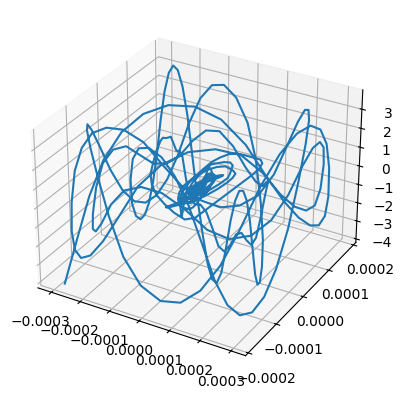

In [1]:
import torch
from transformers import GPT2Tokenizer, GPT2Model
import numpy as np
from sklearn.decomposition import PCA
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Load GPT-2 (small model, dim 768)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')

# Sample ARC-like prompt (e.g., pattern reasoning)
prompt = "Identify the pattern: Input grid [[1,2],[3,4]] -> Output [[4,1],[2,3]] (90 deg rotate). Apply to [[5,6],[7,8]]."
inputs = tokenizer(prompt, return_tensors='pt')
with torch.no_grad():
    outputs = model(**inputs)
latent = outputs.last_hidden_state.squeeze(0).numpy()  # (seq_len, 768) - use token sequence as samples

# Step 1: Dimensionality Reduction (PCA to safe n_components <= seq_len - 1)
n_components = min(32, latent.shape[0] - 1)
pca = PCA(n_components=n_components)
reduced = pca.fit_transform(latent)  # (seq_len, n_components)
reduced_latent = reduced.mean(axis=0)  # Mean-pool to single vector (n_components,)

# Step 2: Define Warped Geodesic (extend Phase 2 to reduced dim)
dim = len(reduced_latent)
target = np.roll(reduced_latent, shift=dim // 4)  # Simulate "90 deg rotate" (shift by dim/4)
M = 10.0
k = 50.0
gamma = 0.1
pull_strength = 1.0
rotation_strength = 0.0  # Disabled for debug

def geodesic_eq(t, y, target):
    pos, vel = y[:dim], y[dim:]
    r = np.linalg.norm(pos)
    if r < 1e-6: r = 1e-6
    warp = - (M / (r**2 + 1e-3)) * (pos / r)
    well = -k * pos / (1 + np.exp(-r))
    rotation = rotation_strength * np.roll(vel, shift=1)
    pull_to_target = pull_strength * (target - pos)
    accel = warp + well + rotation + pull_to_target - gamma * vel
    accel = np.clip(accel, -50, 50)
    return np.concatenate([vel, accel])

# Event for early stop
def converged_event(t, y, target):
    vel = y[dim:]
    return np.linalg.norm(vel) - 1e-3
converged_event.terminal = True
converged_event.direction = -1

# Evolve with solve_ivp, LSODA for mixed stiffness
initial = np.concatenate([reduced_latent * 15.0, np.zeros(dim)])
traj = solve_ivp(geodesic_eq, [0, 20], initial, args=(target,), method='LSODA', rtol=1e-3, atol=1e-3, first_step=0.1, max_step=0.5, events=converged_event)
print("ODE Info:", traj.message)
print("Number of steps taken:", traj.nfev)
pos_traj = traj.y[:dim, :].T

# Interp if >1 point
if len(traj.t) > 1:
    from scipy.interpolate import interp1d
    t_interp = np.linspace(0, traj.t[-1], 500)
    pos_traj_interp = interp1d(traj.t, pos_traj, axis=0)(t_interp)
else:
    pos_traj_interp = pos_traj

# Reconstruct and error
recon_traj = pca.inverse_transform(pos_traj_interp)
final = recon_traj[-1]
recon_target = pca.inverse_transform(target.reshape(1, -1)).squeeze()
error = np.linalg.norm(final - recon_target)
print(f"Convergence Error: {error:.4f}")

# Viz
pca_viz = PCA(n_components=3)
viz_traj = pca_viz.fit_transform(pos_traj_interp)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(viz_traj[:,0], viz_traj[:,1], viz_traj[:,2])
plt.savefig('geodesic_plot.png')

In [103]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import numpy as np
from sklearn.decomposition import PCA
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Load GPT-2 with LM head for logits and hidden states
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

# Sample ARC-like prompt
prompt = "Identify the pattern: Input grid [[1,2],[3,4]] -> Output [[4,1],[2,3]] (90 deg rotate). Apply to [[5,6],[7,8]]."
inputs = tokenizer(prompt, return_tensors='pt')
with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True)
latent = outputs.hidden_states[-1].squeeze(0).numpy()

# Step 1: Dimensionality Reduction (further reduced for speed)
n_components = min(8, latent.shape[0] - 1) # Lower dim for faster ODE
pca = PCA(n_components=n_components)
reduced = pca.fit_transform(latent)
reduced_latent = reduced.mean(axis=0)

# Step 2: Define Warped Geodesic (further softened)
dim = len(reduced_latent)
target = np.roll(reduced_latent, shift=dim // 4)
M = 2.0 # Softened more
k = 10.0 # Softened more
gamma = 0.3 # Increased damping
pull_strength = 1.5
rotation_strength = 0.0

def geodesic_eq(t, y, target):
    pos, vel = y[:dim], y[dim:]
    r = np.linalg.norm(pos)
    if r < 1e-6: r = 1e-6
    warp = - (M / (r**2 + 1e-3)) * (pos / r)
    well = -k * pos / (1 + np.exp(-r))
    rotation = rotation_strength * np.roll(vel, shift=1)
    pull_to_target = pull_strength * (target - pos)
    accel = warp + well + rotation + pull_to_target - gamma * vel
    accel = np.clip(accel, -50, 50)
    return np.concatenate([vel, accel])

# Event for early stop (even looser)
def converged_event(t, y, target):
    vel = y[dim:]
    return np.linalg.norm(vel) - 5e-2 # Looser for quicker stop
converged_event.terminal = True
converged_event.direction = -1

# Evolve (optimized further)
initial = np.concatenate([reduced_latent * 15.0, np.zeros(dim)])
traj = solve_ivp(geodesic_eq, [0, 5], initial, args=(target,), method='LSODA', rtol=1e-1, atol=1e-1, first_step=0.5, max_step=5.0, events=converged_event)
print("ODE Info:", traj.message)
print("Number of steps taken:", traj.nfev)
pos_traj = traj.y[:dim, :].T

# Interp if >1 point
if len(traj.t) > 1:
    from scipy.interpolate import interp1d
    t_interp = np.linspace(0, traj.t[-1], 200) # Fewer points
    pos_traj_interp = interp1d(traj.t, pos_traj, axis=0)(t_interp)
else:
    pos_traj_interp = pos_traj

# Simulate flat-space path (stochastic random walk)
np.random.seed(43)  # Match test seed
flat_steps = len(t_interp)
flat_pos_traj = np.zeros((flat_steps, dim))
flat_pos_traj[0] = reduced_latent * 15.0
for i in range(1, flat_steps):
    noise = np.random.normal(0, 1.0, dim) # Increased noise for visibility
    flat_pos_traj[i] = flat_pos_traj[i-1] + noise # Random walk

# Scale all paths for visibility
scale_factor = 10.0 # Adjust to make paths more pronounced
pos_traj_interp *= scale_factor
flat_pos_traj *= scale_factor
target *= scale_factor

# Reconstruct and error
recon_traj = pca.inverse_transform(pos_traj_interp)
final = recon_traj[-1]
recon_target = pca.inverse_transform(target.reshape(1, -1)).squeeze()
error = np.linalg.norm(final - recon_target)
print(f"Convergence Error: {error:.4f}")

# Viz: Static 3D image of warped and flat path in separate subplots
pca_viz = PCA(n_components=3)
all_pos_traj = np.vstack([pos_traj_interp, flat_pos_traj])  # Fit on all for consistent scale
pca_viz.fit(all_pos_traj)
viz_traj = pca_viz.transform(pos_traj_interp)
viz_flat_traj = pca_viz.transform(flat_pos_traj)
viz_target = pca_viz.transform(target.reshape(1, -1)).squeeze()

fig = plt.figure(figsize=(12, 6))

# Flat path subplot
ax_flat = fig.add_subplot(121, projection='3d')
ax_flat.set_xlabel('PC1'); ax_flat.set_ylabel('PC2'); ax_flat.set_zlabel('PC3')
ax_flat.set_title('Flat Latent Space Path (Stochastic)')
ax_flat.plot(viz_flat_traj[:,0], viz_flat_traj[:,1], viz_flat_traj[:,2], 'b-', label='Flat Space (Stochastic)')
ax_flat.scatter([viz_target[0]], [viz_target[1]], [viz_target[2]], c='green', marker='*', s=200, label='Target (Cognition Well)')
ax_flat.legend()

# Warped path subplot
ax_warped = fig.add_subplot(122, projection='3d')
ax_warped.set_xlabel('PC1'); ax_warped.set_ylabel('PC2'); ax_warped.set_zlabel('PC3')
ax_warped.set_title('Warped Latent Space Path (Convergent)')
ax_warped.plot(viz_traj[:,0], viz_traj[:,1], viz_traj[:,2], 'r-', label='Warped Space (Convergent)')
ax_warped.scatter([viz_target[0]], [viz_target[1]], [viz_target[2]], c='green', marker='*', s=200, label='Target (Cognition Well)')
ax_warped.legend()
plt.savefig('step9_warped_flat_static.png')
plt.close()

# Step 8: Warped Inference
correct_example = "The output is [[8,5],[6,7]]."
example_inputs = tokenizer(correct_example, return_tensors='pt')
with torch.no_grad():
    example_outputs = model(**example_inputs, output_hidden_states=True)
example_latent = example_outputs.hidden_states[-1].mean(dim=1).squeeze().numpy()
reduced_example = pca.transform(example_latent.reshape(1, -1)).squeeze()
nudge_target = reduced_example
def geodesic_nudge(current_reduced, nudge_target):
    t_short = np.linspace(0, 2, 30) # Shorter, fewer points
    initial_short = np.concatenate([current_reduced, np.zeros(dim)])
    traj_short = solve_ivp(geodesic_eq, [0, 2], initial_short, args=(nudge_target,), method='LSODA', rtol=1e-1, atol=1e-1, first_step=0.5, max_step=5.0, events=converged_event)
    print("Nudge ODE Info:", traj_short.message, "Steps:", traj_short.nfev)
    return traj_short.y[:dim, -1]

ODE Info: A termination event occurred.
Number of steps taken: 490
Convergence Error: 0.0012


In [101]:
plt.savefig('step9_warped_flat_static.png')

<Figure size 640x480 with 0 Axes>